In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import complex_ode
from stablab import (semicirc, winding_number, Evans_plot, emcset,
                       Evans_compute, soln, profile_flux, Struct)
from stablab.evans import drury_no_radial, LdimRdim, reflect_image

In [2]:
# Import local_model functions
from local_model import (RH_local_model, H_local_model, 
                         full_gas_Hugoniot, F_local_model,
                         Flinear_local_model,
                         plot_profile_local_model, 
                         A_local_model_balflux)

## Driver for flux and balanced flux formulation for full gas in Lagrangian coordinates

In [3]:
# parameters
S_neg_vals = [-1]  # -3.3 -3.31 #-(4.4:0.1:5);
p = Struct()
s = Struct()

In [4]:
# Solve the profiles
s_old = None
for S in S_neg_vals:

    p.S_neg = S

    p.none = 1
    p.mu = 1
    p.kappa = 1
    p.S0 = 0
    p.tau0 = 1

    # plus and minus infinity end states
    p = RH_local_model(p)

    # phase condition
    s.phase = np.array([0.5*(p.tau_plus+p.tau_neg),0.5*(p.S_plus+p.S_neg)])

    #order in which to apply phase conditions
    s.order = np.array([0,1])

    #profile ode
    s.F = F_local_model

    #Jacobian file
    s.Flinear = Flinear_local_model

    # number of profile equations to integrate
    s.n = 2

    # end states
    s.UL = np.array([p.tau_neg, p.S_neg])
    s.UR = np.array([p.tau_plus, p.S_plus])

    s.stats = 'off'
    # tolerance at end states
    s.tol = 1e-6

    p,s = profile_flux(p,s,s_old)

    s_old = s

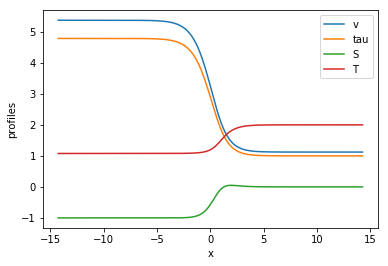

In [5]:
# Plot the profile
plot_profile_local_model(p,s)

In [6]:
# Evans matrix (balanced flux form)
Amat = A_local_model_balflux

In [7]:
# structure variables
s,e,m,c = emcset(s,'front',LdimRdim(Amat,s,p),'default',Amat)

In [8]:
# refine the Evans function computation to achieve set relative error
c.refine = 'on'

# display a waitbar
c.stats = 'off'

m.method = drury_no_radial
R = 10
p.R = R

In [9]:
# Set up the preimage
circpnts = 20; imagpnts = 20; spread = 4; zerodist = 10**(-6);
preimage = semicirc(circpnts,imagpnts,c.ksteps,R,spread,zerodist)

In [10]:
# You could also set up the preimage with:

# circpnts = 20; imagpnts = 20; innerpnts = 7; spread = 4; inner_radius = 10^(-4); lamda_steps = 0;
# preimage = semicirc2(circpnts,imagpnts,innerpnts,c.ksteps,R,spread,inner_radius,lamda_steps);

# or

# c.ksteps = 2^12;
# pnts = 2;
# preimage = linspace(0.1,1e-4,pnts+(pnts-1)*c.ksteps);

In [11]:
# compute Evans function
halfw, domain = Evans_compute(preimage,c,s,p,m,e)
# Normalize the image
w = halfw / halfw[0]
# Reflect it about the imaginary axis
w = reflect_image(w)

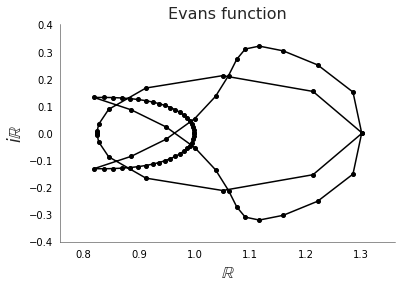

In [12]:
Evans_plot(w)